# Recreating the RW17 Dataset from Scratch

This notebook first explains the datastructure used in (Rehder and Waldmann, 2017)
and then demonstrates how to **construct the RW17 domain components** using helper functions 
from `dataset_creation`, and **convert them into a structured DataFrame**.

We will:
1. **Create a domain dictionary** using `create_domain_dict`
2. **Expand it into a DataFrame** using `expand_domain_to_dataframe`
3. **Add inference tasks** to extend the dataset
4. **Generate verbalized prompts** for human evaluation


This step will:

Load and examine rw_17_domain_components (the predefined dataset components).
Break down its structure to understand:
Domain dictionary (specification of causal variables).
Graph structure (causal relationships).
Inference tasks (reasoning scenarios).
Explain how these elements combine to generate prompts for LLMs.


In [1]:
import os
import sys
import pprint
import pandas as pd

# Ensure Python finds the `src` directory
sys.path.append(os.path.abspath("../../src"))

# Import everything defined in `__all__`
from causalalign.dataset_creation import (
    rw_17_domain_components,
    graph_structures,
    inference_tasks_rw17,
    generate_prompt_dataframe,
    expand_domain_to_dataframe,
    expand_df_by_task_queries,
    create_domain_dict,
    verbalize_domain_intro,
    verbalize_causal_mechanism,
    verbalize_inference_task,
    append_dfs,
)

print("Dataset creation module imported successfully!")


Dataset creation module imported successfully!


# 1. Understanding the RW17 Dataset Structure

Before generating new datasets, we need to understand the structure of **RW17 domain components**.

## 🔹 What Is RW17?
RW17 presented humans with causal inference tasks and asked for their likelihood judgements. Each causal inference task was presented on four subsequent screens.
In the following, I will describe how I translated the experimental materials used by RW17 into nested dictionaries, which serve as the backbone to algorithmically  generate  the materials in RW17 in *textual form* such that we can prompt and compare LLMs' causal judgements. The following notebook explains how to algoritmically re-create the the textual form used by RW17 and also, how to easily create new prompts.

RW17 used 3 different knowledge domains, in particular economy, sociology, and weather, in which the inference tasks were thematically embedded.
Each domain specifies:
- **Variables (`C1`, `C2`, `E`)**: The causal variables / graph nodes, e.g., C1: interest rates
- **Variable Sense depending on binary values 0 or 1 for (`C1`, `C2`, `E`)**: e.g. for C1=1: *high* interest rates
- ** Counterbalance-dependent Sense Assignments (`p/m`)**: How we represent conditions in counterbalanced ways (optional, but used in RW17). Essentially, this flips the senses of what it means for the variable to be on (1) or off (0).

The verbalization of the prompt depends on the domain and:
- **Causal Mechanisms**: How the variables influence each other (e.g., specified by collider, graph or chain graph)
- **Inference Tasks**: The reasoning problems we ask an LLM to solve specified by 

By combining these components, we **generate structured natural language prompts** that can be used for causal reasoning tasks in an LLMs.


##  Understanding the RW17 Domain Dictionary

Each domain in `rw_17_domain_components` contains:
1. **Domain Name & Introduction**:  
   - Explains the overall knowledge structure / cover story the inference task is embedded in.
   
2. **Causal Variables (`C1`, `C2`, `E`)**:  
   - `C1` and `C2` are **causes**, and `E` is the **effect**.
   - Each variable has:
     - A **name** and **detailed description**.
     - `p_value` and `m_value`: Counterbalanced values.
     - **Explanation mappings**: How specific conditions lead to outcomes. (optional, plus, they are graph dependent!)

3. **Example: Economy Domain**
   - `C1`: **Interest Rates** (low vs. high)
   - `C2`: **Trade Deficit** (small vs. large)
   - `E`: **Retirement Savings** (high vs. low)


#### Make sure you understand the building blocks of the dictionary. 

in ``src/causalalign/dataset_creation/constants.py``, there are dictionaries that define the domain building blocks, causal mechanism for 3 different graph topologies (collider, fork, and chain), and inference tasks. Before re-creating the prompts used in RW17, let's first load them and get a feeling for the prompt structure:




In [2]:
# load domain components
rw_17 = rw_17_domain_components


# list the domains in the dataset
print("Domains in the dataset:")
print(rw_17.keys())


# Pretty-print RW17 dataset structure

pprint.pprint(rw_17)

Domains in the dataset:
dict_keys(['economy', 'sociology', 'weather'])
{'economy': {'domain_name': 'economy',
             'introduction': 'Economists seek to describe and predict the '
                             'regular patterns of economic fluctuation. To do '
                             'this, they study some important variables or '
                             'attributes of economies. They also study how '
                             'these attributes are responsible for producing '
                             'or causing one another.',
             'variables': {'C': {'C_detailed': 'Retirement savings is the '
                                               'money people save for their '
                                               'retirement.',
                                 'C_name': 'retirement savings',
                                 'm_value': {'0': 'normal', '1': 'low'},
                                 'p_value': {'0': 'normal', '1': 'high'}},
                

##  How Graph Structures Define Causal Mechanisms

A **graph structure** specifies how causal variables (`A`, `B`, `C`) relate to each other.

### Example Graph Structures:
1. **Collider** (`A → C ← B`)
   - `A` and `B` both cause `C`.

2. **Fork** (`A ← C → B`)
   - `C` causes both `A` and `B`.
   - NOTE: to account for the right permutations when assigning the two possible values to the two effects, we need for consistency swap values `A` with `C`. Since the code assumens that `A_i` and `B_i` are always ther permutable values!

3. **Chain** (`A → B → C`)
   - `A` causes `B`, which then affects `C`.

Let's look at the graph structures dictionary that is already pre-defined in ``src/causalalign/dataset_creation/constants.py``


In [3]:
# Pretty-print available graph structures
pprint.pprint(graph_structures)


{'chain': {'causal_template': '{x_sense} {x_name} causes {y_sense} {y_name}. '
                              'And {y_sense} {y_name} causes {z_sense} '
                              '{z_name}.',
           'description': 'A→B→C'},
 'collider': {'causal_template': '{x_sense} {x_name} causes {z_sense} '
                                 '{z_name}. Also, {y_sense} {y_name} causes '
                                 '{z_sense} {z_name}.',
              'description': 'X→Z←Y'},
 'fork': {'causal_template': '{x_sense} {x_name} causes {y_sense} {y_name}. '
                             'Also, {x_sense} {x_name} causes {z_sense} '
                             '{z_name}.',
          'description': 'B←A→C'}}


##  How Inference Tasks Define the Final Prompt

Inference tasks specify **what the LLM needs to predict** given certain observations.

For example:
- `"a": {"query_node": "Ci", "observation": "Cj=1", "query": "Ci=?"}`
  - **Ask:** Given that `Cj=1`, what is the likely value of `Ci`?
  - This corresponds to **a causal reasoning question**.

Inference tasks work together with **domain dictionaries** and **graph structures** to create **verbalized prompts**.

### 🔗 How It All Connects:
1. **Domain Dictionary** → Specifies **variables and values**.
2. **Graph Structure** → Defines **causal relationships**.
3. **Inference Tasks** → Frame **the reasoning problem**.
4. **Prompt Verbalization** → Converts this into **natural language for LLMs**.



In [4]:
pprint.pprint(inference_tasks_rw17)

{'a': {'observation': 'Z=1, Yj=1',
       'query': 'p(Xi=1|Z=1, Yj=1)',
       'query_node': 'Xi=1'},
 'b': {'observation': 'Z=1', 'query': 'p(Xi=1|Z=1)', 'query_node': 'Xi=1'},
 'c': {'observation': 'Z=1, Yj=0',
       'query': 'p(Xi=1|Z=1, Yj=0)',
       'query_node': 'Xi=1'},
 'd': {'observation': 'Yj=1', 'query': 'p(Xi=1|Yj=1)', 'query_node': 'Xi=1'},
 'e': {'observation': 'Yj=0', 'query': 'p(Xi=1|Yj=0)', 'query_node': 'Xi=1'},
 'f': {'observation': 'Z=0, Yj=1',
       'query': 'p(Xi=1|Z=0, Yj=1)',
       'query_node': 'Xi=1'},
 'g': {'observation': 'Z=0', 'query': 'p(Xi=1|Z=0)', 'query_node': 'Xi=1'},
 'h': {'observation': 'Z=0, Yj=0',
       'query': 'p(Xi=1|Z=0, Yj=0)',
       'query_node': 'Xi=1'},
 'i': {'observation': 'Xi=0, Yj=0',
       'query': 'p(Z=1|Xi=0, Yj=0)',
       'query_node': 'Z=1'},
 'j': {'observation': 'Xi=0, Yj=1',
       'query': 'p(Z=1|Xi=0, Yj=1)',
       'query_node': 'Z=1'},
 'k': {'observation': 'Xi=1, Yj=1',
       'query': 'p(Z=1|Xi=1, Yj=1)',
       

Now, let's explore how these components are combined by re-creating the prompts used in RW17 starting with re-creating the dictionaries that are stored in ``constants.py``!


# Step 1: Create Domain Dictionray:


In [5]:
# Example usage with enforcement of "normal" for zero values
try:
    economy_test_dict = create_domain_dict(
        domain="economy",
        introduction="Economists seek to describe and predict economic fluctuations...",
        X_name="interest rates",
        X_detailed="Interest rates are the rates banks charge to loan money.",
        X_values={"1": "low", "0": "high"},
        Y_name="trade deficits",
        Y_detailed="A country's trade deficit...",
        Y_values={"1": "small", "0": "large"},
        Z_name="retirement savings",
        Z_detailed="Retirement savings is the money people save for their retirement.",
        Z_values={"1": "high", "0": "low"},
        counterbalance_enabled=True,
        enforce_zero_label=True,  # Ensures '0' is verbalized as 'normal'
        zero_label="normal",
    )

    # Convert dictionary to a readable JSON format for display
    import json

    formatted_output = json.dumps(economy_test_dict, indent=4)
    print(formatted_output)

except Exception as e:
    print(f"Error: {e}")

{
    "domain_name": "economy",
    "introduction": "Economists seek to describe and predict economic fluctuations...",
    "variables": {
        "X": {
            "X_name": "interest rates",
            "X_detailed": "Interest rates are the rates banks charge to loan money.",
            "p_value": {
                "1": "low",
                "0": "normal"
            },
            "m_value": {
                "1": "high",
                "0": "normal"
            }
        },
        "Y": {
            "Y_name": "trade deficits",
            "Y_detailed": "A country's trade deficit...",
            "p_value": {
                "1": "small",
                "0": "normal"
            },
            "m_value": {
                "1": "large",
                "0": "normal"
            }
        },
        "Z": {
            "Z_name": "retirement savings",
            "Z_detailed": "Retirement savings is the money people save for their retirement.",
            "p_value": {
           

This should re-create our rw17 dictionary. Let's verify this.

In [6]:
# # display the entire dataframe cell content
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)

# subset_df[["domain", "graph", "cntbl_cond", "prompt"]]

### Comparing Bob's human data 
- file rw17_ce.csv used for cogsci paper (collider)
- new COLLIDER version shared in March 25: rw17_collider_ce.csv
- new FORK version shared in March 25: rw17_fork_cc.csv


#### Loading the data we used for Cogsci as  human_data_cogsci

In [7]:
# load human data COGSCI version
# import human data
human_data_cogsci = pd.read_csv(
    "../data/17_rw/human_data/rw16_ce.csv", sep=";"
)  # used for cogsci

# print the columns
print(human_data_cogsci.columns)
print(human_data_cogsci["label"].unique())
human_data_cogsci.head()

Index(['s', 'domain', 'model', 'diag', 'ppp', 'task', 'type', 'wt', 'y',
       'y_length', 'label', 'y.hat', 'y.hat.pre', 'diff', 'y.hat.prescaled'],
      dtype='object')
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k']


,s,domain,model,diag,ppp,task,type,wt,y,y_length,label,y.hat,y.hat.pre,diff,y.hat.prescaled
0,0,economy,model_only,a,ppp,c,a,1,"82,5",2,a,"73,63187122","0,715710379","8,868128777","0,736318712"
1,0,economy,model_only,a,ppp,c,b,1,"82,5",2,b,"73,67073819","0,727134006","8,82926181","0,736707382"
2,0,economy,model_only,a,ppp,c,c,1,"77,5",2,c,"73,77949013","0,757575715","3,720509875","0,737794901"
3,0,economy,model_only,a,ppp,c,d,1,60,2,d,"70,71811141","0,686898121","10,71811141","0,707181114"
4,0,economy,model_only,a,ppp,c,e,1,"52,5",2,e,"66,42691103","0,686898121","13,92691103","0,66426911"


#### New COLLIDER Human data

In [8]:
human_data_new_ce = pd.read_csv(
    "../data/17_rw/human_data/rw17_collider_ce.csv", sep=";"
)
# rename colum task as label
human_data_new_ce.rename(columns={"letter.type": "label"}, inplace=True)
# print the columns
# turn label into lower case
human_data_new_ce["label"] = human_data_new_ce["label"].str.lower()
# rename attr.polarity to ppp
human_data_new_ce.rename(columns={"attr.polarity": "ppp"}, inplace=True)
# drop task
human_data_new_ce.drop(columns=["task"], inplace=True)
print(human_data_new_ce.columns)

print(human_data_new_ce["label"].unique())
human_data_new_ce.head()


Index(['s', 'domain', 'diagram', 'ppp', 'label', 'study.type', 'trial', 'rt',
       'y', 'type', 'aggr.type', 'betw.factors'],
      dtype='object')
['d' 'j' 'b' 'f' 'c' 'k' 'h' 'e' 'a' 'g' 'i']


,s,domain,diagram,ppp,label,study.type,trial,rt,y,type,aggr.type,betw.factors
0,0,economy,a,ppp,d,Y|X=1,0,"38,788",65,CB|CA=1,Ci|Cj=1,"domain, attr.polarity, diagram, letter.type"
1,0,economy,a,ppp,j,"Z|X=0,Y=1",1,"16,532",80,"E|CA=0,CB=1","E|Ci=0,Cj=1","domain, attr.polarity, diagram, letter.type"
2,0,economy,a,ppp,b,X|Z=1,2,"10,979",90,CA|E=1,Ci|E=1,"domain, attr.polarity, diagram, letter.type"
3,0,economy,a,ppp,f,"X|Y=1,Z=0",3,"17,956",55,"CA|E=0,CB=1","Ci|E=0,Cj=1","domain, attr.polarity, diagram, letter.type"
4,0,economy,a,ppp,c,"Y|X=0,Z=1",4,"9,54",60,"CB|E=1,CA=0","Ci|E=1,Cj=0","domain, attr.polarity, diagram, letter.type"


### Compare if for both human data collider versions the unique identifiers map to the response (y)

In [9]:
## merge the two dataframes on ppp, label and domain
merged_human_collider = pd.merge(
    human_data_new_ce,
    human_data_cogsci,
    on=["ppp", "label", "domain", "s"],
    how="inner",
)
# print the columns
print(merged_human_collider.columns)

# now select the following columns: s_x, y_x, domain, label, s_y, y_y
merged_human_collider_select = merged_human_collider[
    ["s", "y_y", "y_x", "domain", "label", "ppp", "study.type", "aggr.type"]
]

# turn both y_x and y_y into float, replacing commas with dots if necessary
merged_human_collider_select["y_x"] = merged_human_collider_select["y_x"].astype(float)
merged_human_collider_select["y_y"] = (
    merged_human_collider_select["y_y"].replace(",", ".", regex=True).astype(float)
)
print(merged_human_collider_select.columns)


Index(['s', 'domain', 'diagram', 'ppp', 'label', 'study.type', 'trial', 'rt',
       'y_x', 'type_x', 'aggr.type', 'betw.factors', 'model', 'diag', 'task',
       'type_y', 'wt', 'y_y', 'y_length', 'y.hat', 'y.hat.pre', 'diff',
       'y.hat.prescaled'],
      dtype='object')
Index(['s', 'y_y', 'y_x', 'domain', 'label', 'ppp', 'study.type', 'aggr.type'], dtype='object')


/var/folders/y0/vrnztzg51jb867hg02f76f800000gn/T/ipykernel_12768/2470615921.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_human_collider_select["y_x"] = merged_human_collider_select["y_x"].astype(float)
/var/folders/y0/vrnztzg51jb867hg02f76f800000gn/T/ipykernel_12768/2470615921.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_human_collider_select["y_y"] = (


In [10]:
# now add a column difference that takes the difference between y_x and y_y
merged_human_collider_select["difference_ys"] = (
    merged_human_collider_select["y_x"] - merged_human_collider_select["y_y"]
)
merged_human_collider_select.head()

/var/folders/y0/vrnztzg51jb867hg02f76f800000gn/T/ipykernel_12768/3771898066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_human_collider_select["difference_ys"] = (


,s,y_y,y_x,domain,label,ppp,study.type,aggr.type,difference_ys
0,0,60.0,65.0,economy,d,ppp,Y|X=1,Ci|Cj=1,5.0
1,0,60.0,55.0,economy,d,ppp,X|Y=1,Ci|Cj=1,-5.0
2,0,80.0,80.0,economy,j,ppp,"Z|X=0,Y=1","E|Ci=0,Cj=1",0.0
3,0,80.0,80.0,economy,j,ppp,"Z|X=1,Y=0","E|Ci=0,Cj=1",0.0
4,0,82.5,90.0,economy,b,ppp,X|Z=1,Ci|E=1,7.5


[  5.   -5.    0.    7.5  -7.5 -17.5  17.5  15.  -15.    2.5  -2.5  10.
 -10.  -20.   20.  -12.5  12.5 -25.   25.   32.5 -32.5  50.  -50.  -22.5
  22.5 -37.5  37.5 -47.5  47.5  30.  -30.   27.5 -27.5  35.  -35. ]


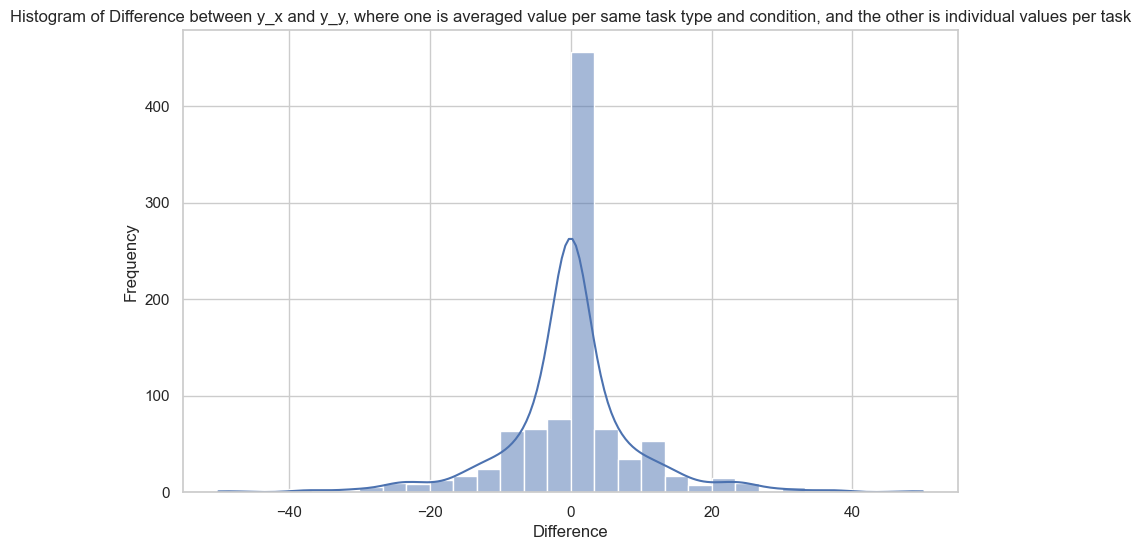

In [11]:
# print all unique values in the column difference_ys
print(merged_human_collider_select["difference_ys"].unique())

# plot a histogram of the difference_ys column
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")
# Set the figure size
plt.figure(figsize=(10, 6))
# Plot the histogram
sns.histplot(merged_human_collider_select["difference_ys"], bins=30, kde=True)
# Set the title and labels
plt.title(
    "Histogram of Difference between y_x and y_y, where one is averaged value per same task type and condition, and the other is individual values per task"
)
plt.xlabel("Difference")
plt.ylabel("Frequency")
# Show the plot
plt.show()

- The histogram shows that between the per condition (domain, task, ppp), the difference in response between aggregated and and individual response per subject per condition triplet is mostly zero, as expected. #
- For the Cogsci Submission, I only had access to the aggregated human data per  condition (domain, task, ppp): i.e., in the collder verbalizations, for the same task, the C1 and C2 where flipped, but the data I had access to, only reflected the averaged pairs (2 responses per condition)


### Next, Load  Fork human data and compar the node varibles and task labels (a-k) to collider
-

In [12]:
human_data_fork = pd.read_csv("../data/17_rw/human_data/rw17_fork_cc.csv", sep=";")
# rename colum task as label
human_data_fork.rename(columns={"letter.type": "label"}, inplace=True)
# print the columns
# turn label into lower case
human_data_fork["label"] = human_data_fork["label"].str.lower()
# rename attr.polarity to ppp
human_data_fork.rename(columns={"attr.polarity": "ppp"}, inplace=True)
# drop task
human_data_fork.drop(columns=["task"], inplace=True)
print(human_data_fork.columns)

print(human_data_fork["label"].unique())
human_data_fork.head()

Index(['s', 'domain', 'diagram', 'ppp', 'label', 'study.type', 'b', 't', 'rt',
       'y', 'type', 'aggr.type', 'betw.factors'],
      dtype='object')
['d' 'i' 'k' 'h' 'e' 'f' 'b' 'g' 'a' 'c' 'j']


,s,domain,diagram,ppp,label,study.type,b,t,rt,y,type,aggr.type,betw.factors
0,2,weather,A,ppp,d,"XorY=1,Z=?(X?)",1,1,"23,18",80,EA|EB=1,Ei|Ej=1,"domain, attr.polarity, diagram, letter.type"
1,2,weather,A,ppp,i,p(C|0E)/v00,1,2,"11,26",20,"C|EA=0,EB=0","C|EA=0,EB=0","domain, attr.polarity, diagram, letter.type"
2,2,weather,A,ppp,k,p(C|2E)/v11,1,3,"7,91",100,"C|EA=1,EB=1","C|EA=1,EB=1","domain, attr.polarity, diagram, letter.type"
3,2,weather,A,ppp,h,"XorY=0,Z=0(Y?)",1,4,"25,1",25,"EB|C=0,EA=0","Ei|C=0,Ej=0","domain, attr.polarity, diagram, letter.type"
4,2,weather,A,ppp,e,"XorY=0,Z=?(Y?)",1,5,"10,6",5,EB|EA=0,Ei|Ej=0,"domain, attr.polarity, diagram, letter.type"


In [13]:
### merke new collider and fork data frames on label
merged_human_fork_collider_label = pd.merge(
    human_data_fork,
    human_data_new_ce,
    on=["label", "domain", "ppp"],
    how="inner",
)

In [14]:
print(merged_human_fork_collider_label.columns)
# select columns label and study.type_x, study.type_y, and aggr.type_x, aggr.type_y
merged_human_fork_collider_label_select = merged_human_fork_collider_label[
    [
        "label",
        "domain",
        "study.type_x",
        "study.type_y",
        "aggr.type_x",
        "aggr.type_y",
        "ppp",
    ]
]

# rename the columns
merged_human_fork_collider_label_select.rename(
    columns={
        "study.type_x": "fork_study_type",
        "study.type_y": "collider_study_type",
        "aggr.type_x": "fork_task_type",
        "aggr.type_y": "collider_task_type",
    },
    inplace=True,
)
print("shape: ", merged_human_fork_collider_label_select.shape)
merged_human_fork_collider_label_select.head()

Index(['s_x', 'domain', 'diagram_x', 'ppp', 'label', 'study.type_x', 'b', 't',
       'rt_x', 'y_x', 'type_x', 'aggr.type_x', 'betw.factors_x', 's_y',
       'diagram_y', 'study.type_y', 'trial', 'rt_y', 'y_y', 'type_y',
       'aggr.type_y', 'betw.factors_y'],
      dtype='object')
shape:  (7296, 7)


/var/folders/y0/vrnztzg51jb867hg02f76f800000gn/T/ipykernel_12768/801092077.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_human_fork_collider_label_select.rename(


,label,domain,fork_study_type,collider_study_type,fork_task_type,collider_task_type,ppp
0,d,weather,"XorY=1,Z=?(X?)",Y|X=1,Ei|Ej=1,Ci|Cj=1,ppp
1,d,weather,"XorY=1,Z=?(X?)",X|Y=1,Ei|Ej=1,Ci|Cj=1,ppp
2,d,weather,"XorY=1,Z=?(X?)",X|Y=1,Ei|Ej=1,Ci|Cj=1,ppp
3,d,weather,"XorY=1,Z=?(X?)",Y|X=1,Ei|Ej=1,Ci|Cj=1,ppp
4,d,weather,"XorY=1,Z=?(X?)",X|Y=1,Ei|Ej=1,Ci|Cj=1,ppp


In [15]:
# print all unique rows where the row for label, , aggr.type_y, aggr.type_x, is unique
task_label_collider_fork_mapping = merged_human_fork_collider_label_select[
    ["label", "collider_task_type", "fork_task_type"]
].drop_duplicates()
print(task_label_collider_fork_mapping)

    label collider_task_type fork_task_type
0       d            Ci|Cj=1        Ei|Ej=1
80      i        E|CA=0,CB=0    C|EA=0,EB=0
100     k        E|CA=1,CB=1    C|EA=1,EB=1
120     h        Ci|E=0,Cj=0    Ei|C=0,Ej=0
200     e            Ci|Cj=0        Ei|Ej=0
280     f        Ci|E=0,Cj=1    Ei|C=0,Ej=1
360     b             Ci|E=1         Ei|C=1
440     g             Ci|E=0         Ei|C=0
520     a        Ci|E=1,Cj=1    Ei|C=1,Ej=1
600     c        Ci|E=1,Cj=0    Ei|C=1,Ej=0
680     j        E|Ci=0,Cj=1    C|Ei=0,Ej=1


In [16]:
## for comparison, let's add a column of the task stored in the dictionary (cogsci based)
inference_tasks_rw17


{'a': {'query_node': 'Xi=1',
  'observation': 'Z=1, Yj=1',
  'query': 'p(Xi=1|Z=1, Yj=1)'},
 'b': {'query_node': 'Xi=1', 'observation': 'Z=1', 'query': 'p(Xi=1|Z=1)'},
 'c': {'query_node': 'Xi=1',
  'observation': 'Z=1, Yj=0',
  'query': 'p(Xi=1|Z=1, Yj=0)'},
 'd': {'query_node': 'Xi=1', 'observation': 'Yj=1', 'query': 'p(Xi=1|Yj=1)'},
 'e': {'query_node': 'Xi=1', 'observation': 'Yj=0', 'query': 'p(Xi=1|Yj=0)'},
 'f': {'query_node': 'Xi=1',
  'observation': 'Z=0, Yj=1',
  'query': 'p(Xi=1|Z=0, Yj=1)'},
 'g': {'query_node': 'Xi=1', 'observation': 'Z=0', 'query': 'p(Xi=1|Z=0)'},
 'h': {'query_node': 'Xi=1',
  'observation': 'Z=0, Yj=0',
  'query': 'p(Xi=1|Z=0, Yj=0)'},
 'i': {'query_node': 'Z=1',
  'observation': 'Xi=0, Yj=0',
  'query': 'p(Z=1|Xi=0, Yj=0)'},
 'j': {'query_node': 'Z=1',
  'observation': 'Xi=0, Yj=1',
  'query': 'p(Z=1|Xi=0, Yj=1)'},
 'k': {'query_node': 'Z=1',
  'observation': 'Xi=1, Yj=1',
  'query': 'p(Z=1|Xi=1, Yj=1)'}}

In [17]:
# First, create a dictionary that maps the label to the query
label_to_query = {k: v["query"] for k, v in inference_tasks_rw17.items()}

# Then, add the column to the DataFrame
task_label_collider_fork_mapping["cogsci_sub_task_collider"] = (
    task_label_collider_fork_mapping["label"].map(label_to_query)
)


In [18]:
task_label_collider_fork_mapping

,label,collider_task_type,fork_task_type,cogsci_sub_task_collider
0,d,Ci|Cj=1,Ei|Ej=1,p(Xi=1|Yj=1)
80,i,"E|CA=0,CB=0","C|EA=0,EB=0","p(Z=1|Xi=0, Yj=0)"
100,k,"E|CA=1,CB=1","C|EA=1,EB=1","p(Z=1|Xi=1, Yj=1)"
120,h,"Ci|E=0,Cj=0","Ei|C=0,Ej=0","p(Xi=1|Z=0, Yj=0)"
200,e,Ci|Cj=0,Ei|Ej=0,p(Xi=1|Yj=0)
280,f,"Ci|E=0,Cj=1","Ei|C=0,Ej=1","p(Xi=1|Z=0, Yj=1)"
360,b,Ci|E=1,Ei|C=1,p(Xi=1|Z=1)
440,g,Ci|E=0,Ei|C=0,p(Xi=1|Z=0)
520,a,"Ci|E=1,Cj=1","Ei|C=1,Ej=1","p(Xi=1|Z=1, Yj=1)"
600,c,"Ci|E=1,Cj=0","Ei|C=1,Ej=0","p(Xi=1|Z=1, Yj=0)"


#### Further preprocessing of cogsci human data

In [19]:
## rename the columns
human_data_cogsci["domain"].unique()
human_data_cogsci["domain"] = human_data_cogsci["domain"].replace(
    {"society": "sociology"}
)
# rename ppp column with cntbl_cond
human_data_cogsci = human_data_cogsci.rename(columns={"ppp": "cntbl_cond"})
# rename s with subj_id
human_data_cogsci = human_data_cogsci.rename(columns={"s": "human_subj_id"})  # in rw17
## add column subject that contains humans everywhere
human_data_cogsci["subject"] = "human"
# add a column graph that contains collider everywhere
human_data_cogsci["graph"] = "collider"
# drop task column
human_data_cogsci = human_data_cogsci.drop(columns=["task"])
# rename label with task
human_data_cogsci = human_data_cogsci.rename(columns={"label": "task"})
# rename column y with response
human_data_cogsci = human_data_cogsci.rename(columns={"y": "response"})
# drop the following columns: y.hat', 'y.hat.pre', 'diff', 'y.hat.prescaled' , 'wt', label, type, diag, model
human_data_cogsci = human_data_cogsci.drop(
    columns=[
        "y.hat",
        "y.hat.pre",
        "diff",
        "y.hat.prescaled",
        "wt",
        "type",
        "diag",
        "model",
    ]
)
# print the columns
# rename y_length with num_responses_agg
human_data_cogsci = human_data_cogsci.rename(columns={"y_length": "num_responses_agg"})


### Save cleaned, raw  human Data 

In [20]:
# save humna data
# human_data_cogsci.to_csv("../datasets/17_rw/human_data/human_cleaned_coll.csv", index=False)
print(human_data_cogsci.columns)

Index(['human_subj_id', 'domain', 'cntbl_cond', 'response',
       'num_responses_agg', 'task', 'subject', 'graph'],
      dtype='object')
